libraries for Computing:
- 
- Tensorflow / keras: used for training the model 
- PIL :               used for image processing
- Numpy:              used for numerical computation
- Os   :              used for joining the path

In [22]:
import os
import glob
import h5py
from PIL import Image
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam , SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras import backend as K
import numpy as np

Loading Data
-
- Uaing imagedatagenerator for reading/loading images from directory
- batch_size used for how many images read togather
- Rescal meaning image into 0,1
- target size mean images dimension(height, width,channel)
- 4000 images for training and 1000 images for testing

In [23]:
batch_size = 16          #  was 16 for validation

train_images = '/content/drive/MyDrive/Face Data/FaceShape Dataset/training_set'
test_images = '/content/drive/MyDrive/Face Data/FaceShape Dataset/testing_set'

Train_Datagen = ImageDataGenerator(
               preprocessing_function= preprocess_input, horizontal_flip = True )

val_Datagen = ImageDataGenerator(
                preprocessing_function= preprocess_input )

train_data = Train_Datagen.flow_from_directory( train_images, target_size = (224, 224),
                                              batch_size =batch_size, class_mode = 'categorical' )

batches = val_Datagen.flow_from_directory( test_images, target_size = (224, 224),
                                             batch_size = 1000, class_mode = 'categorical')


Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


Creating labels
-
- sperate images and labels from dataset
- checks the dataset categories indexes

In [24]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

imgs, labels = next(batches)

batches.class_indices

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

splitting dataset
- 
- training data already splitting 4000 images
- using python libraries sklearn 
- testing data 1000 images
- Splitting 50% testing and validation 50% data

In [25]:
print(imgs.shape)
print(labels.shape)

print("*********************************")

from sklearn.model_selection import train_test_split
# Train, validation and test split

X_val, X_test, y_val, y_test = train_test_split(imgs,labels, test_size=0.5, random_state=7)



(1000, 224, 224, 3)
(1000, 5)
*********************************


In [26]:
print("*-*-*-*-*-*")
print("Train")
print(X_val.shape)
print(y_val.shape)

print("*-*-*-*-*-*")
print("Test")
print(X_test.shape)
print(y_test.shape)

*-*-*-*-*-*
Train
(500, 224, 224, 3)
(500, 5)
*-*-*-*-*-*
Test
(500, 224, 224, 3)
(500, 5)


Building CNN Model
- 
- images size 224,224,3
- activation 'relu'
- Convent2d, maxpooling, batchnormalization
- Dense layers, flatten layers
- drpout and 'softmax'

In [27]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [28]:
model =  build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

Compile the model
-
- set the learning rate is 0.0001
- adding early stoping
- matrix accuracy

In [29]:
# opt = RMSprop(lr=0.0001, decay=1e-6)

opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=5,min_delta= .05, monitor="val_acc")
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

Fitting method for training
- 
- training and validation data
- epochs 50
- callbacks

In [30]:
# Fit the model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
                    train_data,
                    validation_data = (X_val, y_val) ,              
                    epochs = 50,
                    callbacks=[es,chkpt]
                    )

Epoch 1/50
250/250 [==============================] - 88s 346ms/step - loss: 1.6071 - accuracy: 0.2130 - val_loss: 1.6100 - val_accuracy: 0.1820
Epoch 2/50
250/250 [==============================] - 81s 324ms/step - loss: 1.5785 - accuracy: 0.2573 - val_loss: 1.6087 - val_accuracy: 0.1860
Epoch 3/50
250/250 [==============================] - 81s 324ms/step - loss: 1.5208 - accuracy: 0.3120 - val_loss: 1.5523 - val_accuracy: 0.3200
Epoch 4/50
250/250 [==============================] - 75s 299ms/step - loss: 1.4731 - accuracy: 0.3445 - val_loss: 1.5725 - val_accuracy: 0.3600
Epoch 5/50
250/250 [==============================] - 80s 318ms/step - loss: 1.4127 - accuracy: 0.3988 - val_loss: 1.4476 - val_accuracy: 0.3520
Epoch 6/50
250/250 [==============================] - 75s 300ms/step - loss: 1.3663 - accuracy: 0.4162 - val_loss: 1.4620 - val_accuracy: 0.3680
Epoch 7/50
250/250 [==============================] - 80s 319ms/step - loss: 1.3260 - accuracy: 0.4350 - val_loss: 1.3954 - val_ac

In [2]:
Visualize Accuracy and Loss
-
- importing matplotlib and seaborn libraries for ploting graphs
- Training accuracy and validation accuracy graphs
- Training loss and validation loss graphs

SyntaxError: invalid syntax (Temp/ipykernel_3472/3855620232.py, line 1)

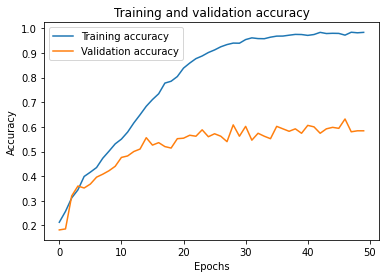

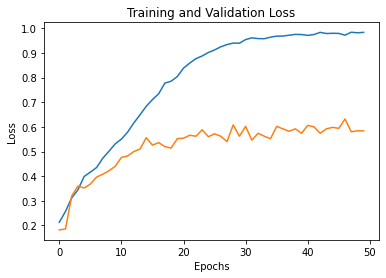

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot using Seaborn

plt.plot(history.history['accuracy'], label="Training loss")
plt.plot(history.history['val_accuracy'], label="Validation loss")
#my_plot = sns.lineplot(data=history[["loss","validation_loss"]])
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend(labels=["Training", "Validation"])
plt.title('Training and Validation Loss')
plt.show()

In [33]:
model.save("Face_shape.h5")

Testing the model on unseen data
-
- Evaluate method used for testing
- putting the unseen data

In [44]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 2s 99ms/step - loss: 1.8275 - accuracy: 0.6120


[1.8274928331375122, 0.6119999885559082]

In [34]:
import numpy as np
import pandas as pd
y_test.shape

(500, 5)

In [35]:
y_pred = model.predict(X_test, verbose=0)
y_pred.shape

(500, 5)

Confusion matrix
-
- import confusion matrix from sklearn
- predict the model 
- plot the confusion matrix graphs

In [36]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [37]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

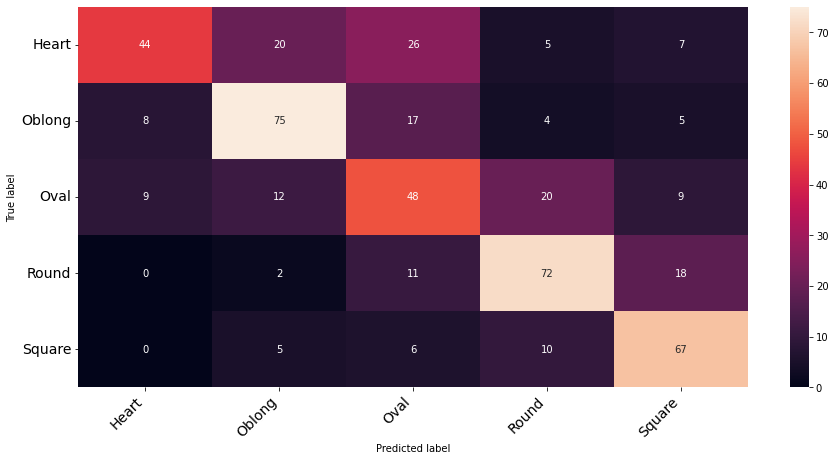

In [42]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (15,7), fontsize=14)

Creating Classification Report
- 
- import classification report from sklearn
- predicting the value
-  classification report on CNN model

In [41]:
# From categorical outputs to discrete values

y_pred_ = [np.argmax(y) for y in y_pred]
y_test_ = [np.argmax(y) for y in y_test]

from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

           0       0.72      0.43      0.54       102
           1       0.66      0.69      0.67       109
           2       0.44      0.49      0.47        98
           3       0.65      0.70      0.67       103
           4       0.63      0.76      0.69        88

    accuracy                           0.61       500
   macro avg       0.62      0.61      0.61       500
weighted avg       0.62      0.61      0.61       500



The End
-